# MARS5001 Coastal Processes and Systems


# NB2 - Generation of Bathymetry Grid

<p>The objective of this notebook is to upload and transform a XYZ ASCII topographic/bathymetric data that will later be use to set a model grid for our next simulation. </p>

<p>The data manipulation preserves the georeferencing information of the DEM, allowing later projection of the model in a GIS client (or Google Earth).</p>

<p>First we upload the libraries that we will use...</p>

In [1]:
%pylab inline
%matplotlib inline
import os
import csv
import glob
import netCDF4
import matplotlib
import subprocess
import pandas as pd
import numpy as np
import scipy.io as spio
import matplotlib.tri as Tri
import myOSshell as myos
import matplotlib.pyplot as plt
from matplotlib import animation
from distutils.dir_util import mkpath
from matplotlib.colors import BoundaryNorm

Populating the interactive namespace from numpy and matplotlib


# XYZ dataset

In 2005 Geoscience Australia and the National Oceans Office undertook a joint project to produce a consistent, high-quality 9 arc second (**0.0025°** or **~250m** at the equator) bathymetric grid for Australian waters. 

In 2009 a number of new datasets were included in an updated version of the grid. 

<small>*Reference: Whiteway, T., 2009. Australian Bathymetry and Topography Grid, June 2009. Scale 1:5000000. Geoscience Australia, Canberra. http://dx.doi.org/10.4225/25/53D99B6581B9A*
</small>

In [1]:
from IPython.core.display import HTML
HTML('<iframe src=http://www.ga.gov.au/metadata-gateway/metadata/record/gcat_67703 width=600 height=500></iframe>')

# Cliping the Dataset

The total size of the ASCII files for all Australia is about 2.5 Gb and is organized as follow:

<img src='./XYZ_Index.jpg' width=400>

So the XYZ ASCII files consist in a series of tiles. For offshore Sydney area, I've picked the following tiles:

+ Tile 7d
+ Tile 8c
+ Tile 11b
+ Tile 12a

And I did a bit of processing on my laptop before uploading the XYZ file on the Amazon server (mainly due to space issue). Basically I have cropped the initial series of 4 tiles between:

+ 151.149,153.336
+ -35.2013,-32.1437

The obtained cropped file called **bath.csv** is around 32 Mb.

To upload the file to the server I've first set up a Dropbox account:

+ name mars5001
+ surname usyd
+ mail tristan.salles@sydney.edu.au
+ password mars5001

then uploaded the file to the Dropbox account and finally used the following script to upload it from the Dropbox account to the Amazon server: 

In [2]:
def dropbox_download(REMOTE,OUTDIR):
    # Get the current working directory
    working_path=os.getcwd()
    # Prepare the shell command
    dropbox_download='(~/Dropbox-Uploader/dropbox_uploader.sh download '+REMOTE+' '+working_path+'/'+OUTDIR+')'
    # download file from dropbox
    os.system(dropbox_download)

In [3]:
#dropbox_download('bath.csv','.')

In [4]:
%ls

bath.csv  grid.csv  Lecture-overview.ipynb  myOSshell.py  myOSshell.pyc  NB1-SWE2D.ipynb  NB2-BathymetryGen.ipynb  pyclaw.log  SydCoast/


# UTM projected map

First we need to read the ASCII file. To do so we use **Pandas** library..,

In [2]:
import pandas as pd
d = pd.read_csv('bath.csv')
X=d['Points:0']
Y=d['Points:1']
Z=d['Points:2']
print X[1],Y[1],Z[1]

geoX = []
geoY = []
geoZ = []

for i in range(X.shape[0]):
    geoX.append(X[i])
    geoY.append(Y[i])
    geoZ.append(Z[i])

151.15125 -32.14375 535


To convert from long/lat to UTM coordinates we use **Proj4** library...

We first set the projection referential:

In [3]:
from pyproj import Proj
projection = Proj(proj='utm',zone='56S',ellps='WGS84')
projection.srs

'+units=m +ellps=WGS84 +proj=utm +zone=56S '

Then we perform this projection to the long/lat coordinates:

In [4]:
uX = []
uY = []
uZ = []

for i in range(X.shape[0]):
    ox,oy = projection(geoX[i],geoY[i])
    uX.append(ox)
    uY.append(oy)
    uZ.append(geoZ[i]-1.)

We then create a regular grid at 250 m resolution which takes the coast between Botany Bay and Manly:

In [5]:
step=250
isx= int( (359000-330000) / step )+1
isy = int( (-3730500+3769000) / step )+1
xi = np.linspace(330000, 359000,isx)
yi = np.linspace(-3769000, -3730500,isy)
nX,nY = np.meshgrid(xi, yi)
nZ = griddata(uX, uY, uZ, xi, yi)
print nZ.min(),nZ.max(),nZ.shape

-154.164230428 187.523950101 (155, 117)


# Plot the projected map

In [6]:
# Use custom colormap function from Earle
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

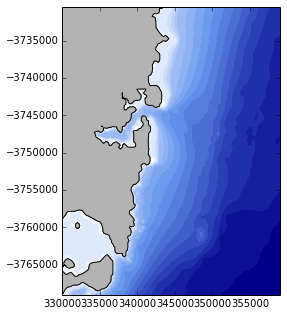

In [8]:
blevels = [-150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40, -30, -20, -10,  -7.5, -5, -2.5,-1,-0.5,0]
Nb = len(blevels)-1

cmap = custom_div_cmap(Nb, mincol='DarkBlue', midcol='CornflowerBlue' ,maxcol='w')
cmap.set_over('0.7') # light gray

bnorm = BoundaryNorm(blevels, ncolors=Nb, clip=False)

fig, ax = plt.subplots(1,1, figsize=(3.9,5.16))
pc = plt.contourf(nX,nY,nZ,  vmin=-150, vmax=0, levels=blevels, norm=bnorm, cmap=cmap, extend='both')
#plt.colorbar(pc, ticks=blevels, spacing='uniform')

pc = plt.contour(nX,nY,nZ, levels=[0], colors='k')

# Coupled ocean/wave bathymetric input file 

You will create your own directory that you will use to run your own ocean/wave model of Offshore Sydney.
<br/>
The directory will contain a folder called **data** in which you will store the Sydney DEM that we've just produced. 
<br/>
First we create the 2 directories:

In [11]:
%ls
#myos.mkdir('./SydOceanT')
#myos.mkdir('./SydOceanT/data')
myos.list_dir('./SydOceanT')

bath.csv  gab/  Lecture-overview.ipynb  myOSshell.py  myOSshell.pyc  NB1-SWE2D.ipynb  NB2-BathymetryGen.ipynb  SydOceanT/  XYZ_Index.jpg
['./SydOceanT/data']


The format of the input grid for our coupled ocean/wave model is an ASCII file containing on each line the following variables:
<br/>
** NID  Xvalue Yvalue Zvalue**
<br/>
The (X,Y) values should be ordered starting from the SW corner up to the NE ones going first along the X-axis. To create this grid we do:

In [15]:
file = 'sydney.nodes'
ofile  = open(file, "wb")
writer = csv.writer(ofile, delimiter=' ')

# There are no header on this file
#d = []
#d.append('x')
#d.append('y')
#d.append('z')
#writer.writerow(d)

nid = 0
for i in range(nZ.shape[0]):
    for j in range(nZ.shape[1]):
        nid = nid + 1
        d = []
        d.append(nid)
        d.append(nX[i,j])
        d.append(nY[i,j])
        d.append(nZ[i,j])
        writer.writerow(d)

ofile.close()

We then move the file *sydney.nodes* to the simulation folder in my case: *./SydOceanT/data*

In [19]:
%ls
# Copy file
#myos.copy('sydney.nodes','./SydOceanT/data')
# List data directory
#myos.list_dir('./SydOceanT/data')
# Delete copied file from root
#myos.delete('sydney.nodes')

bath.csv  gab/  Lecture-overview.ipynb  myOSshell.py  myOSshell.pyc  NB1-SWE2D.ipynb  NB2-BathymetryGen.ipynb  SydOceanT/  XYZ_Index.jpg
